# Semi-Supervised Learning (SSL)

## Clemence GRISLAIN


SSL studies how to learn from both labeled and unlabeled data, which can be useful when data is abundant but the resources to label them are limited.

In this exercise, you will:

* Given a simulated dataset with both labeled and unlabeled data, build a similarity graph and use the Harmonic Function Solution (HSF) to predict the labels of the unlabeled data;
* Use HSF for face recognition, given a fixed dataset;
* Implement an online version of HSF to label images as they appear in real time.

## 1. Harmonic Function Solution

Let $G = (V, E)$ be a weighted undirected graph where $V = \{x_1, \ldots, x_n \}$ is the vertex set and $E$ is the edge set. Each edge $e_{ij} \in E$ has a weight $w_{ij}$ and, if there is no edge between $x_i$ and $x_j$, then $w_{ij}=0$.

Let $|V| = n$ be the total number of nodes. Only a subset of the nodes $S \subset V$ with cardinality $|S| = l$ is labeled, and the remaining $u = n - l$ nodes are placed in the subset $T = V \setminus S$. 

Our goal is to predict the labels of the vertices in $T$ using the structure of the graph. Since we believe that nodes close in the graph should have similar labels, we would like to have each node surrounded by a majority of nodes with the same label. In order to do so, we impose that the labeling vector $f \in \mathbb{R}^n$ must be an **harmonic function** on the graph, that is:

$$
f_i = \frac{\sum_{j} w_{ij} f_j}{\sum_{j} w_{ij}},  \forall i \in T
$$

One interpretation for this constraint is that $w_{ij}$ represents the tendency of moving from node $x_i$ to node $x_j$, the stationary distribution of the transition matrix $P(j|i) = \tfrac{w_{ij}}{\sum_{k} w_{ik}}$  is a valid solution to our problem. 

### Hard HFS

It can be shown that $f$ is harmonic if and only if $(Lf)_T = 0$, where $(Lf)_T$ is the vector containing the values of $Lf$ for the nodes in the set $T$, and $L$ is the graph Laplacian. 

Hence, the harmonic function solution to the SSL problem is the solution to the following optimization problem:

$$
\min_{f \in \mathbb{R}^n}  f^T L f  
\quad \text{s.t} \quad
y_i = f(x_i) \quad \forall x_i \in S
$$
where $y_i$ are the labels available for the vertices $x_i \in S$. This gives us:

$$
f_T = L_{TT}^{-1}(W_{TS}f_S) = - L_{TT}^{-1}(L_{TS}f_S) 
$$

### Soft HFS

If the labels are noisy, we might need to replace the "hard" constraint of the optimization problem above by a "soft" constraint. Let $C$ be a diagonal matrix such that $C_{ii} = c_l$ for labeled examples and $C_{ii} = c_u$ otherwise. Also, define $y_i = 0$ for unlabeled examples, that is, for $x_i \in T$. 

The soft HFS objective function is

$$
\min_{f\in\mathbb{R}^n} (f-y)^T C (f-y) + f^T L f
$$
whose solution is 

$$
f^* = (C^{-1}L+I)^{-1}y
$$


### Implementation

Implement hard and soft HFS in the function `compute_hfs`. Complete the function `two_moons_hfs` to test your implementation using the datasets `data_2moons_hfs.mat` and `data_2moons_hfs_large.mat`.


* Tips: 
    * Don't forget to choose well the parameters to build the graph and its Laplacian.
    * You can use the functions `build_laplacian_regularized` and `build_similarity_graph`. The function `mask_labels` is used to chose how many labels are revealed.
    * Be careful: the labels are revealed randomly, and each random realization can have different results! Check how the `seed` parameter works.
    * Introduce noisy labels to compare hard and soft HFS.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial.distance as sd
from scipy.io import loadmat
import os
from helper import build_similarity_graph, label_noise
from helper import build_laplacian, build_laplacian_regularized
from helper import plot_classification
from helper import mask_labels
from PIL import Image
from skimage import io

In [7]:
"""
Define parameters for HFS
"""
params = {}

# regularization parameter (gamma)
params['laplacian_regularization'] = 0.0

# the sigma value for the exponential (similarity) function, already squared
params['var'] = 1.0

# Threshold eps for epsilon graphs
params['eps'] = None

# Number of neighbours k for k-nn. If zero, use epsilon-graph
params['k'] = 10

# String selecting which version of the laplacian matrix to construct.
# 'unn':  unnormalized, 'sym': symmetric normalization, 'rw':  random-walk normalization 
params['laplacian_normalization'] = 'rw'

# Coefficients for C matrix for soft HFS
params['c_l'] = 0.80
params['c_u'] = 0.2

In [3]:
def compute_hfs(L, Y, soft=False, **params):
    """
    TO BE COMPLETED

    Function to perform HFS (hard or soft!).

    Parameters
    ----------
    L : array
        Graph Laplacian, (n x n) matrix (regularized or not)
    Y : array
        (n, ) array with nodes labels [0, 1, ... , num_classes] (0 is unlabeled)
    soft : bool
        If True, compute soft HFS. Otherwise, compute hard HFS.

    Returns
    --------
        Labels, class assignments for each of the n nodes
    """

    num_samples = L.shape[0]
    Cl = np.unique(Y)
    num_classes = len(Cl)-1

    """
    Build the vectors:
    y = (n x num_classes) target vector 
    l_idx = shape (l,) vector with indices of labeled nodes
    u_idx = shape (u,) vector with indices of unlabeled nodes
    """
    l_idx = np.where(Y != 0)[0]
    u_idx = np.where(Y == 0)[0]
    y = np.zeros((num_samples, num_classes))
    for i in l_idx: y[i, int(Y[i]) - 1] = 1

    if not soft:    
        """
        Compute hard HFS.  

        f_l = solution for labeled data. 
        f_u = solution for unlabeled data
        f   = solution for all data
        """
        f_l = y[l_idx,:]
        Luu = L[np.ix_(u_idx, u_idx)]
        Lul = L[np.ix_(u_idx, l_idx)]
        f_u = - np.linalg.pinv(Luu) @ (Lul @ f_l)
    
        f = np.zeros((num_samples, num_classes))
        f[l_idx, :] = f_l
        f[u_idx, :] = f_u
        
    else:
        """
        Compute soft HFS.
        f = harmonic function solution 
        C = (n x n) diagonal matrix with c_l for labeled samples and c_u otherwise    
        """
        c = np.zeros(num_samples)
        c[l_idx] = params['c_l']
        c[u_idx] = params['c_u']
        
        C = np.diag(c)
        Q = L + params['laplacian_regularization'] * np.identity(num_samples)
        
        f = np.linalg.inv(np.linalg.inv(C) @ Q + np.identity(num_samples)) @ y

    """
    return the labels assignment from the hfs solution, and the solution f
    labels: (n x 1) class assignments [1,2,...,num_classes]    
    f : harmonic function solution
    """

    labels = np.argmax(f, axis=1) + 1

    return labels, f


In [4]:
def two_moons_hfs(l=4, l_noisy=1, soft=False, dataset='data_2moons_hfs.mat', plot=True, seed=None, **params):
    """    
    TO BE COMPLETED.

    HFS for two_moons data.
    
    Parameters
    ----------
    l : int
        Number of labeled (unmasked) nodes provided to the HFS algorithm.
    l_noisy : int
        Number of *noisy* labels to introduce.
    soft : bool
        If true, use soft HFS, otherwise use hard HFS
    dataset : {'data_2moons_hfs.mat' or 'data_2moons_hfs_large.mat'}
        Which dataset to use.
    plot : bool
        If True, show plots
    seed : int
        If not None, set global numpy seed before choosing labels to reveal.
    """
    if seed is not None:
        np.random.seed(seed)

    # Load the data. At home, try to use the larger dataset.    
    in_data = loadmat(os.path.join('data', dataset))
    X = in_data['X']
    Y = np.array(in_data['Y'].squeeze(), dtype=np.uint32)

    # infer number of labels from samples
    num_samples = np.size(Y, 0)
    unique_classes = np.unique(Y)
    num_classes = len(unique_classes)
    
    # mask labels
    Y_masked = mask_labels(Y, l, per_class=True)
    assert len(np.unique(Y_masked)) > 2, "only one class in training data!"
    # introduce noise
    noise_indices = np.where(Y_masked == 0)[0]
    np.random.shuffle(noise_indices)
    noise_indices = noise_indices[:l_noisy]
    Y_masked[noise_indices] = np.random.choice(unique_classes, l_noisy)

    """
    compute hfs solution using either soft_hfs or hard_hfs
    """
    # Build graph Laplacian using the parameters:
    # params['laplacian_regularization'], params['var'], params['eps'], 
    # params['k'] and params['laplacian_normalization'].
    

    L = build_laplacian_regularized(X, laplacian_regularization=params['laplacian_regularization'], 
                                        var=params['var'], 
                                        eps=params['eps'],
                                        k=params['k'],
                                        laplacian_normalization=params['laplacian_regularization'])

    labels, f = compute_hfs(L, Y_masked, soft, **params)

    # Visualize results
    if plot:
        plot_classification(X, Y, Y_masked, noise_indices, labels, params['var'], params['eps'], params['k'])
    accuracy = np.mean(labels == np.squeeze(Y))
    print(f"Soft={soft}, Accuracy={accuracy}")
    return X, Y, labels, accuracy

### Question 1.1 - Report the accuracy you obtained for `data_2moons_hfs.mat` dataset using hard HFS, when l=10 and l_noisy=0. 

**Answers Q1.1**
The hard HFS algorithm based on KNN similarity graph with $k=10$ and random-walk regularised Laplacian, reaches an accuracy of **1.** on the small dataset 'ata_2moons_hfs.mat'.

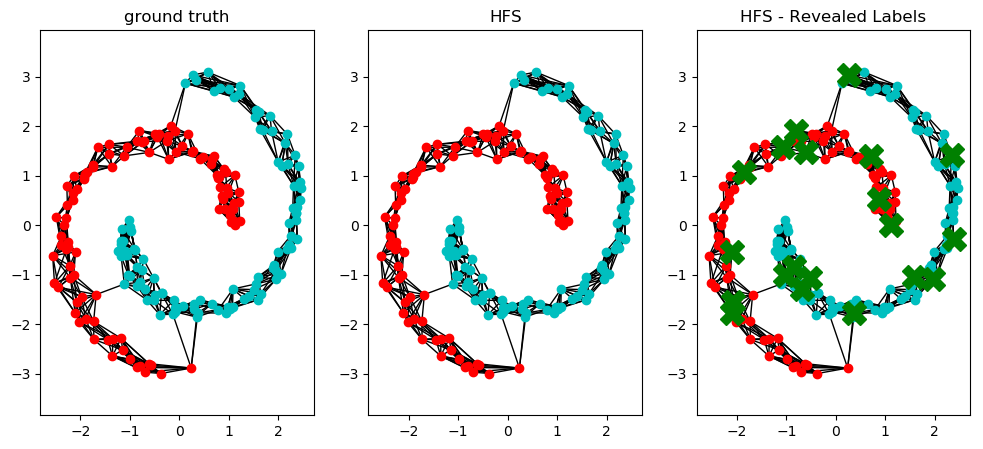

Soft=False, Accuracy=1.0


In [5]:
seed = 42
X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=0, soft=False, dataset='data_2moons_hfs.mat',
                                                 plot=True, seed=seed, **params)

### Question 1.2  - Using `data_2moons_hfs_large.mat`, run `two_moons_hfs` several times with l=4. What can go wrong?

* Tips:
    * When running `two_moons_hfs` several times, don't forget to set `seed=None`

**Answers Q1.2**

With a small parameter $l$, typically $l=4$, it happends that there is no labeled point for one (or more) cluster, leading to an error. 

To solve this problem, when doing the masking with the function 'mask_labels', we set the variable 'per_class' to 'True' in oder to reveal $l$ labels per clusters instead of $l$ labels in total. 

In [ ]:
np.random.seed(42)
for ii in range(20):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=4, l_noisy=0, soft=False, 
                                                     dataset='data_2moons_hfs_large.mat',
                                                     plot=False, seed=None, **params)
    
#mask_labels?  # check parameters

Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0
Soft=False, Accuracy=1.0


### Question 1.3 - Using `data_2moons_hfs.mat`, l=10 and l_noisy=5, compare hard HFS to soft HFS. Report the accuracy and comment the results.

**Answers Q1.3**

For the soft HFS algorithm, we construct the $C$ matrix with coefficients : $c_l=0.8$ and $c_u=0.2$. Like in th eprevious experiment, we use random-walk regularised Laplacian on KNN similarity graph with $k$ choosen according to the size of the dataset.

*  On 'data_2moons_hfs.mat' we set $k=10$ ans observe that the soft HFS is almost always better ($90\%$ of the times in the 10 runs) than the hard HFS: on the 10 runs, the hard HFS achieves a mean accuracy of $0.9595$ whereas the soft HFS achieves a mean accuracy of $0.9815$.
*  On the larger dataset, to ensure the connectivity, we set $k=45$ and observe similar results: the soft HFS always achieves an accuracy of $1.0$ and is always better than the hard HFS. Whereas the hard HFS achieves a mean accuracy of $0.9826$ on the 10 runs. In fact, the hard HFS algorithm cannot reaches perfect clustering if there are mislabeled points as it cannot predict a different cluster than the one the point is labelled with. 

#### Small dataset

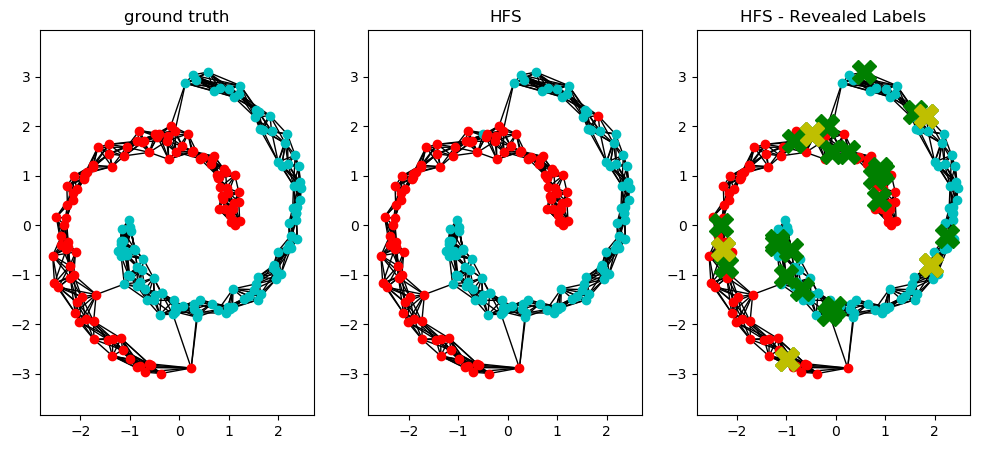

Soft=False, Accuracy=0.99


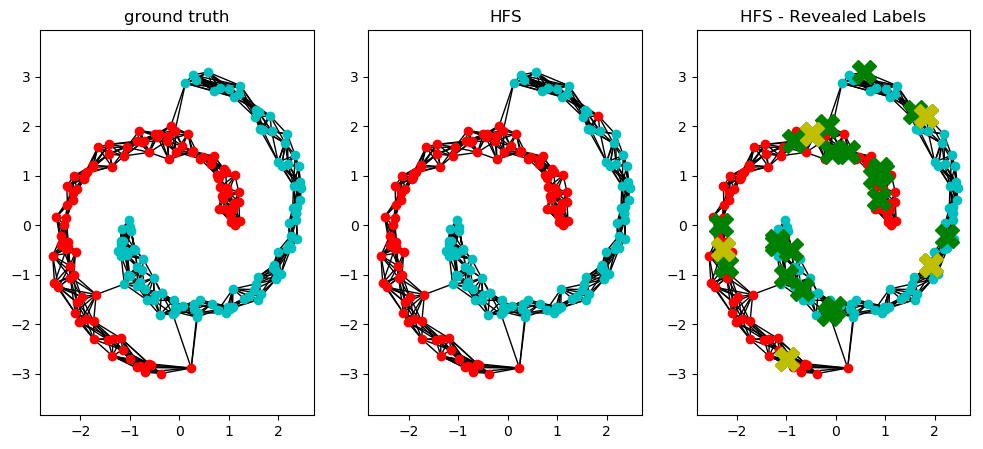

Soft=True, Accuracy=0.995


In [ ]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

In [ ]:
# Comparing
seed = None  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = False
dataset = 'data_2moons_hfs.mat' # Try also 'data_2moons_hfs_large.mat'
for ii in range(10):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                    plot=plot, seed=seed, **params)
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                    plot=plot, seed=seed, **params)

Soft=False, Accuracy=0.995
Soft=True, Accuracy=0.99
Soft=False, Accuracy=0.9
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.87
Soft=True, Accuracy=0.94
Soft=False, Accuracy=0.965
Soft=True, Accuracy=0.995
Soft=False, Accuracy=0.985
Soft=True, Accuracy=0.995
Soft=False, Accuracy=0.985
Soft=True, Accuracy=0.905
Soft=False, Accuracy=0.97
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.99
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.94
Soft=True, Accuracy=0.995
Soft=False, Accuracy=0.995
Soft=True, Accuracy=0.995


#### Large dataset

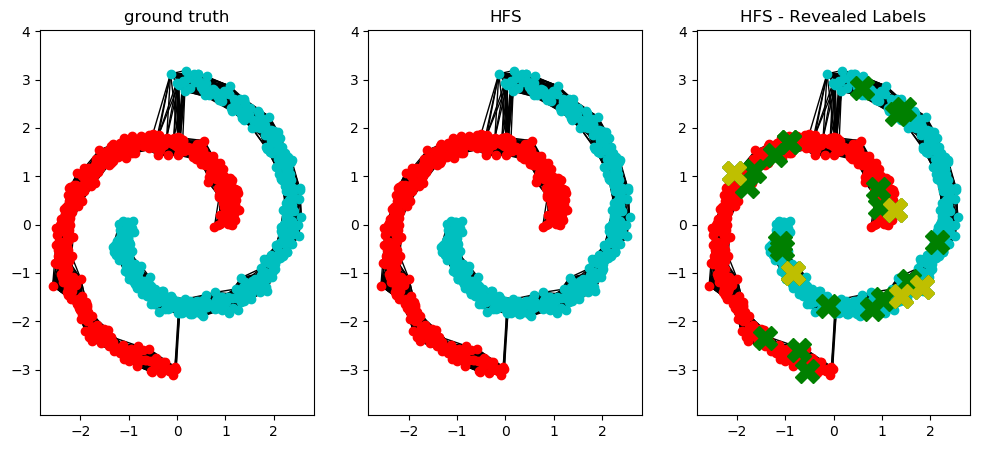

Soft=False, Accuracy=1.0


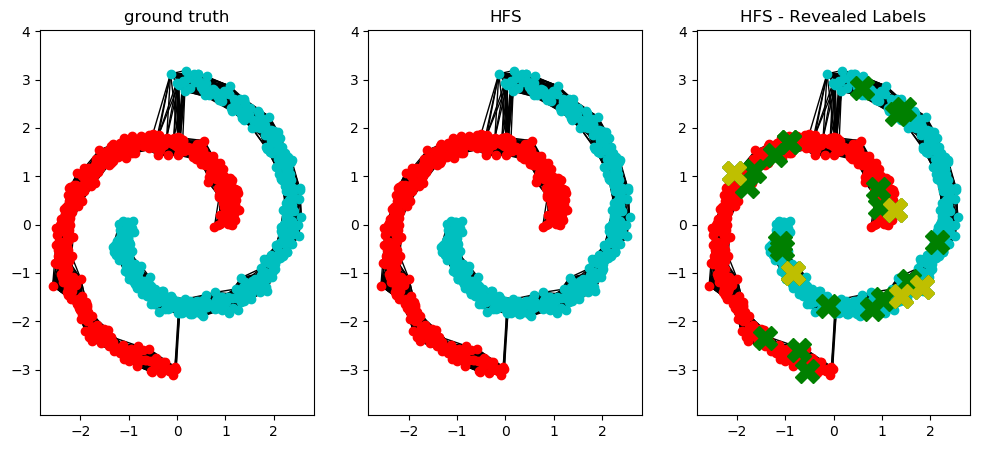

Soft=True, Accuracy=1.0


In [8]:
# Comparing
seed = 5  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = True 
dataset = 'data_2moons_hfs_large.mat'

X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                 plot=plot, seed=seed, **params)
X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                 plot=plot, seed=seed, **params)

In [ ]:
# Comparing
seed = None  # To run several times with random outcomes, set seed=None. Otherwise, set a seed for reproducibility.
plot = False
dataset = 'data_2moons_hfs_large.mat'
for ii in range(10):
    X, Y, hard_labels, hard_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=False, dataset=dataset,
                                                    plot=plot, seed=seed, **params)
    X, Y, soft_labels, soft_accuracy = two_moons_hfs(l=10, l_noisy=5, soft=True, dataset=dataset,
                                                    plot=plot, seed=seed, **params)

Soft=False, Accuracy=0.948
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.997
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.998
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.997
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.943
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.953
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.997
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.998
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.998
Soft=True, Accuracy=1.0
Soft=False, Accuracy=0.997
Soft=True, Accuracy=1.0


## 2. Face recognition with HFS

Now, we apply HFS to the task of face recognition, that is, our goal is to classify faces as belonging to different people. Since faces all share common features, it can be a good idea to leverage a large quantity of unlabeled data to improve classification accuracy. In this part of the exercise, you will:

* Extract faces from the images using OpenCV for face detection, and use the same library to apply preprocessing steps;
* Run HFS for classification.

### Implementation

Choose the hyperparameters and run HFS for face recognition, using both the small and large dataset. You can try to change the preprocessing steps (e.g. equalizeHist, GaussianBlur) applied to the images.

**Important**: make sure your HFS code is able to handle more than two classes!

### Question 2.1 - How did you manage to label more than two classes?

**Answers 2.1**
To label more than two classes we implemented a one hot representation for the labels such that the target vector $y\in \mathbb{R}^{N\times n_{classes}}$ and $y[i,j]=1$ if and only if the the point $i$ is labelled with the class $j$ and $0$ otherwise. This way, the model prediction $Y$ for one data point $i$ is $Y[i]\in\mathbb{R}^{n_{classes}}$ and represents the score of $i$ belonging to the classes (like an unormalized probability). To do the final prediction, we take the argmax over the columns (and add +1 as the indices start at 0 and the classes at 1) 
$$l_i = argmax(Y[i,:])+1$$

### Question 2.2 - Report the best accuracy you obtained for both (small and augmented) datasets.

* Tips:
    * The small dataset (10 images per person) is loaded with `load_image_data`.
    * Use `load_image_data_augmented` for the augmented dataset (50 images per person). 

**Answers Q2.2**

In the preprocessing method, we replaced the Histogram Equalization with Adaptive Histogram Equalization (AHE). While both techniques aim to enhance the contrast of the image, AHE adapts to small regions of the image to reduce over-enhancement and loss of detail. We also experimented with various filters before and after applying the Histogram Equalization, including Median, Gaussian, and Bilateral Filtering, using different parameters. However, the best result was obtained by using only AHE followed by a Median filter with a kernel size of 3.

We used the same HFS parameters for both datasets: the random-walked regularized Laplacian with a regularized factor of 0., built on a KNN graph with 5 neighbors and a variance of 100, and used Soft HFS with coefficients $c_l=90$ and $c_u=2$.

*  On the **small dataset** with 10 images per person, we achieves an accuracy of $86\%$.
*  On the **big dataset** with 50 images per person, we achieves an accuracy of $61\%$

### Question 2.3 - If the accuracy changes when using the augmented dataset, explain why. Does using additional data always increase the performance?

**Answers Q2.3**

We observe that the accuracy on the augmented dataset decreases by approximately 25%. This might be counter-intuitive, as we might expect that more data provides more information and thus better classification. However, in our case, the additional data are unlabelled, which means that the global percentage of labelled data in the semi-supervised learning (SSL) problem decreases. As a consequence, the average confidence in the predictions on the graph also decreases, and errors can more easily propagate in the HFS method.

This shows that adding more data to a problem does not always increase performance, especially when it comes to unlabelled data. When additional labeled data are added, it does provide more information to the model. However, this information can be redundant or noisy, or the model may be too small to learn the extra features. All of these factors can lead to stagnant performance or even worsen it.

In [10]:
import matplotlib.pyplot as plt
from imageio import imread
import numpy as np
import cv2
import os

from load_images import load_image_data, plot_image_data
from load_images import load_image_data_augmented, plot_image_data_augmented

In [13]:
# Function to preprocess the images
# You may try to change it and check the impact on the classification accuracy
def preprocess_image(image):
    """
    Parameters
    ----------
    image : array
        (width, height) array representing a grayscale image
    
    Returns
    -------
        (96, 96) preprocessed image
    """
    output_frame_size = 96   # do not change the output frame size!

    # Blur before
    #image = cv2.medianBlur(image, 3)
    #image = cv2.GaussianBlur(image, (5, 5), 0)
    #image = cv2.bilateralFilter(image, 9, 75, 75)
    
    # Histogram equalization
    #image = cv2.equalizeHist(image)
    clahe = cv2.createCLAHE(clipLimit=40.0, tileGridSize=(5,5))
    image = clahe.apply(image)

    # Blur after
    image = cv2.medianBlur(image, 3)
    #image = cv2.GaussianBlur(image, (5, 5), 0)
    #image = cv2.bilateralFilter(image, 5, 75, 75)

    im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)
    
    # Normalization
    im -= im.mean()
    im /= im.max()
    image = im
    return image

#### Small dataset

In [188]:
dataset_type = 'small_10'

"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.
params_face_rec['var'] = 100.0
params_face_rec['eps'] = None
params_face_rec['k'] = 5
params_face_rec['laplacian_normalization'] = 'rw'
params_face_rec['c_l'] = 90
params_face_rec['c_u'] = 2

data/10faces/0/01.jpg
data/10faces/0/02.jpg
data/10faces/0/03.jpg
data/10faces/0/04.jpg
data/10faces/0/05.jpg
data/10faces/0/06.jpg
data/10faces/0/07.jpg
data/10faces/0/08.jpg
data/10faces/0/09.jpg
data/10faces/0/10.jpg
data/10faces/1/01.jpg
data/10faces/1/02.jpg
data/10faces/1/03.jpg
data/10faces/1/04.jpg
data/10faces/1/05.jpg
data/10faces/1/06.jpg
data/10faces/1/07.jpg
data/10faces/1/08.jpg
data/10faces/1/09.jpg
data/10faces/1/10.jpg
data/10faces/2/01.jpg
data/10faces/2/02.jpg
data/10faces/2/03.jpg
data/10faces/2/04.jpg
data/10faces/2/05.jpg
data/10faces/2/06.jpg
data/10faces/2/07.jpg
data/10faces/2/08.jpg
data/10faces/2/09.jpg
data/10faces/2/10.jpg
data/10faces/3/01.jpg
data/10faces/3/02.jpg
data/10faces/3/03.jpg
data/10faces/3/04.jpg
data/10faces/3/05.jpg
data/10faces/3/06.jpg
data/10faces/3/07.jpg
data/10faces/3/08.jpg
data/10faces/3/09.jpg
data/10faces/3/10.jpg
data/10faces/4/01.jpg
data/10faces/4/02.jpg
data/10faces/4/03.jpg
data/10faces/4/04.jpg
data/10faces/4/05.jpg
data/10fac

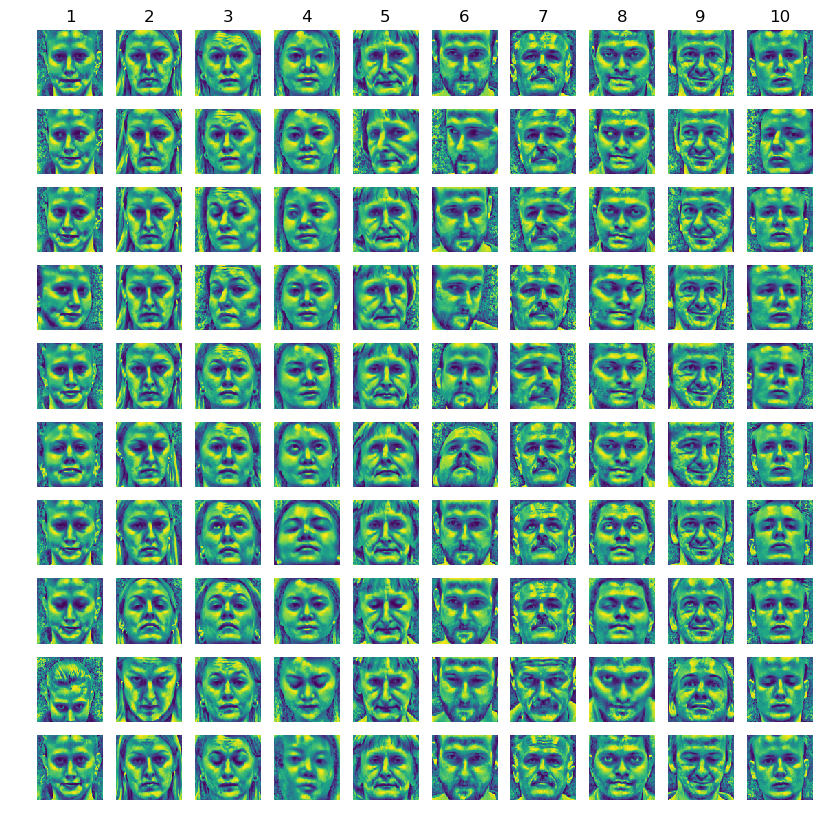

(100, 9216)
[[ 1.  2.  0.  0.  0.  6.  7.  8.  0.  0.]
 [ 1.  2.  0.  4.  0.  0.  7.  0.  0.  0.]
 [ 1.  0.  3.  0.  0.  0.  0.  0.  9.  0.]
 [ 1.  0.  3.  0.  0.  6.  0.  0.  9. 10.]
 [ 0.  0.  0.  4.  5.  6.  0.  8.  0.  0.]
 [ 0.  0.  0.  4.  5.  0.  0.  0.  0.  0.]
 [ 0.  2.  3.  0.  0.  0.  0.  0.  9. 10.]
 [ 0.  0.  0.  0.  5.  6.  7.  0.  0. 10.]
 [ 0.  0.  0.  0.  5.  0.  0.  8.  9. 10.]
 [ 0.  2.  3.  4.  0.  0.  7.  8.  0.  0.]]


In [190]:
# 10 images per person
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data(preprocess_image)

# Uncomment below if you want to visualize the images
plot_image_data(images)
print(images.shape)
print(masked_labels.reshape(-1, 10))

##### Perform HFS clustering

  HFS on small_10 dataset 
Accuracy =  0.86


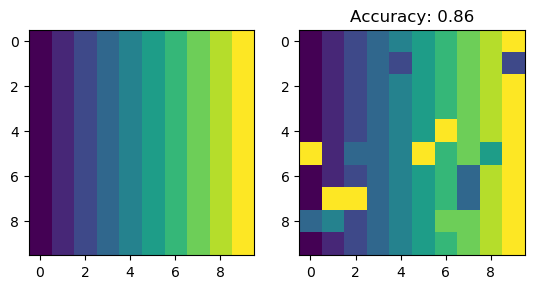

In [191]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])
# Run HFS
print('\033[1m  HFS on {} dataset \033[0m'.format(dataset_type))

predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

#print(masked_labels)
#print(predicted_labels)
#print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()


#### Augmented Dataset

In [186]:
dataset_type = 'big_50'

"""
Define parameters for face recognition with HFS
"""
params_face_rec = {}
params_face_rec['laplacian_regularization'] = 0.
params_face_rec['var'] = 100.0
params_face_rec['eps'] = None
params_face_rec['k'] = 5
params_face_rec['laplacian_normalization'] = 'rw'
params_face_rec['c_l'] = 90
params_face_rec['c_u'] = 2

In [172]:
np.random.seed(456)
# 50 images per person
images, labels, masked_labels = load_image_data_augmented(preprocess_image)
#plot_image_data_augmented(images)

##### Perform HFS clustering on the Big dataset

  HFS on big_50 dataset 
Accuracy =  0.612


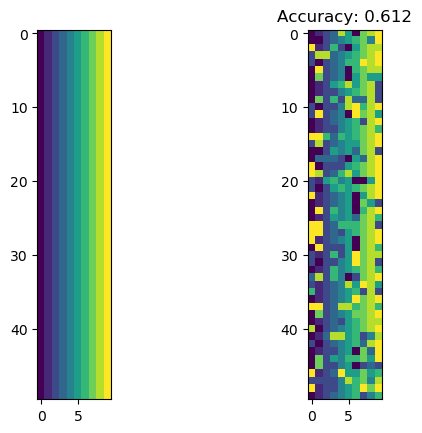

In [187]:
# graph Laplacian
L = build_laplacian_regularized(images, 
                                params_face_rec['laplacian_regularization'], 
                                params_face_rec['var'], 
                                params_face_rec['eps'], 
                                params_face_rec['k'], 
                                params_face_rec['laplacian_normalization'])

# Run HFS
print('\033[1m  HFS on {} dataset \033[0m'.format(dataset_type))

predicted_labels, f = compute_hfs(L, masked_labels, soft=True, **params_face_rec)
accuracy = np.equal(predicted_labels, labels).mean()
print("Accuracy = ", accuracy)

#print(masked_labels)
#print(predicted_labels)
#print(labels)
# Visualize predicted vs true labels
plt.subplot(121)
plt.imshow(labels.reshape((-1, 10)))
plt.subplot(122)
plt.imshow(predicted_labels.reshape((-1, 10)))
plt.title("Accuracy: {}".format(accuracy))
plt.show()

## 3. Online SSL

Now, instead of having all the data available at once, images will be received online: at each time $t$, a new image $x_t$ is observed and the algorithm has to output a label $y_t$. 

Use the function `create_user_profile` to capture a training set of labeled data (of your face and someone else). The faces will be preprocessed and saved in the folder `data/faces`. They will be loaded by `online_face_recognition`.


### Implementation

Choose the hyperparameters and complete the functions `online_ssl_update_centroids` and `online_ssl_compute_solution`. 

Modify your code to be able to disregard faces it cannot recognize.

* Tips:
    * You can use the functions `build_similarity_graph` and `build_laplacian`.

### Question 3.1 - Attach to this notebook some of the resulting frames of online face recognition. 

* Tips: 
    * You can save the resulting frame and add it to the notebook in a markdown cell as `![title](picture.png)`

**Answers Q3.1**

We obtained satisfactory results on online SSl.

* We observed that the algorithm successfully identified my face even in the case of out-of-label-distribution online data, such as when the face is wearing different glasses.
*  The screenshots were captured after several minutes of running the algorithm. Good predictions made at the beginning of the run contributed to reaching better predictions as the database correctly "solidified" and thus the centroids model which get correctly more confident.

**Remark**: we changed the parameters from the last question. In fact, a null value for the Laplacian regularization was leading the algorithm to misclassify with very high confidence. We also notice that increasing the variance and working wih an unormalized Laplacian provided better results.

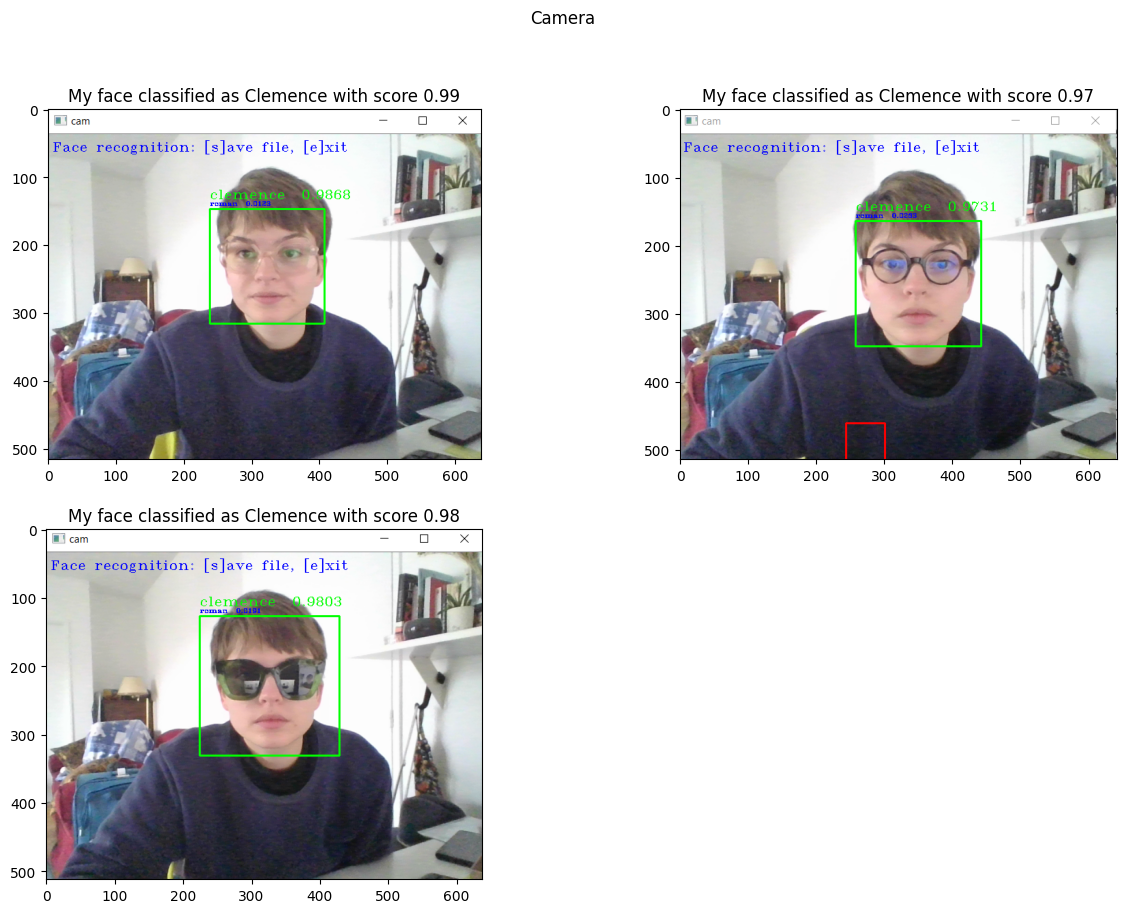

In [129]:
# Harry Potter movie scene
images = [io.imread("results/clemence_1.PNG"),
          io.imread("results/clemence_2.PNG"),
          io.imread("results/clemence_3.PNG")
          ]
scores = [.9868, 0.9731, 0.9803]

fig = plt.figure(figsize=(15,10))

for idx,im in enumerate(images):
    fig.add_subplot(2,2,idx+1)
    plt.imshow(im)
    plt.title(f"My face classified as Clemence with score {str(np.round(scores[idx], 2))}")
fig.suptitle("Camera")
plt.show()



### Question 3.2 - What strategy did you use to label a face as unknown? Attach to this notebook an example of a unknown face being correctly labeled as unknown.

* Tips
    * If you identify a face as unknown, you can return `[("unknown", score)]` from the function `online_ssl_compute_solution`.


**Answers Q3.2**

To label a face as unknown, we apply a hard threshold on the algorithm's prediction confidence. The score returned by the algorithm reflects its level of confidence in its prediction. If the maximum score/confidence among the known classes is below a certain threshold (from the experiments, we set the threshold to **0.85**), the face is labeled as "unknown". To have a score encapsulating the confidence of the algorithm of the person been a new face, we chose $$1 - max_{\text{classes i}}(score_i)$$

In the the Harry Potter movie scene, the algorithm succesfully labels new faces as unknown, as shown for Hemione.


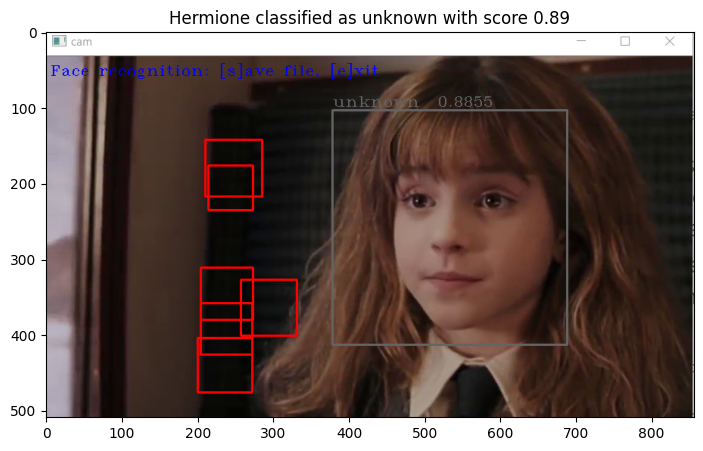

In [130]:
# Harry Potter movie scene
fig = plt.figure(figsize=(10,5))
im = io.imread("results/harry_1.PNG")
score = 0.8855
plt.imshow(im)
plt.title(f"Hermione classified as unknown with score {np.round(score, 2)}")
plt.show()


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import sys
from scipy.spatial import distance
import scipy.io as sio

from helper_online_ssl import create_user_profile, online_face_recognition, online_face_recognition_updated

In [156]:
"""
Define parameters for face recognition with HFS
"""
params_online_ssl = {}
params_online_ssl['laplacian_regularization'] = 0.1
params_online_ssl['var'] = 10000.0
params_online_ssl['eps'] = None
params_online_ssl['k'] = 5
params_online_ssl['laplacian_normalization'] = 'unn'
params_online_ssl['c_l'] = 90
params_online_ssl['c_u'] = 2

In [188]:
class IncrementalKCenters:
    def __init__(self, labeled_faces, labels, label_names, max_num_centroids=50):
        #  Number of labels
        self.n_labels = max(labels)

        #  Dimension of the input image
        self.image_dimension = labeled_faces.shape[1]

        #  Check input validity
        assert (set(labels) == set(
            range(1, 1 + self.n_labels))), "Initially provided faces should be labeled in [1, max]"
        assert (len(labeled_faces) == len(labels)), "Initial faces and initial labels are not of same size"

        #  Number of labelled faces
        self.n_labeled_faces = len(labeled_faces)

        # Model parameter : number of maximum stored centroids
        self.max_num_centroids = max_num_centroids

        # Model centroids (inital labeled faces). Shape = (number_of_centroids, dimension)
        self.centroids = labeled_faces

        # Centroids labels
        self.Y = labels
        
        # Label names (= user names)
        self.label_names = label_names

        # Variables that are initialized in online_ssl_update_centroids()
        self.centroids_distances = None
        self.taboo = None
        self.V = None
        self.init = True

        # index of x_t (initialized later)
        self.last_face = None
    
    def initialize(self):
        """
        Initialization after the first time that the maximum number of centroids is reached.
        """       
        #  Compute the centroids distances
        self.centroids_distances = distance.cdist(self.centroids, self.centroids)

        #  set labeled nodes and self loops as infinitely distant, to avoid merging labeled centroids
        np.fill_diagonal(self.centroids_distances, +np.Inf)
        self.centroids_distances[0:self.n_labeled_faces, 0:self.n_labeled_faces] = +np.Inf

        # put labeled nodes in the taboo list
        self.taboo = np.array(range(self.centroids.shape[0])) < self.n_labeled_faces

        # initialize multiplicity
        self.V = np.ones(self.centroids.shape[0])


    def online_ssl_update_centroids(self, face):
        """
        TO BE COMPLETED

        Update centroids, multiplicity vector V, labels Y.
        
        Note: In Y, set label to 0 for unlabeled faces.

        Parameters
        ----------
        face : array
            New sample
        
        Returns
        --------
        List with the scores for each possible label:
            [(label_1, score_1), (label_2, score_2), ...]
        """

        assert (self.image_dimension == len(face)), "new image not of good size"

        # Case 1: maximum number of centroids has been reached.
        if self.centroids.shape[0] >= self.max_num_centroids + 1:
            if self.init:
                #  Initialization after the first time that the maximum number of centroids is reached
                self.initialize()
                self.init = False
            """
            Find c_rep and c_add following Algorithm 1.
            
            - c_1, c_2 = two closest centroids (minimum distance) such that at least one of them is not in self.taboo.
            - c_rep = centroid in {c_1, c_2} that is in self.taboo. If none of them is in self.taboo, c_rep is the one
                      with largest multiplicity.
            - c_add = centroid in {c_1, c_2} that is not c_rep.
            """

            # Found c_1 and c_2
            indexes = np.argsort(self.centroids_distances.ravel())
            for idx in indexes:
                c_1, c_2 = np.unravel_index(idx, self.centroids_distances.shape)
                if (c_1 not in self.taboo) or (c_2 not in self.taboo):
                    break

            # Decision rule for c_rep and c_add
            if c_1 in self.taboo:
                c_rep = c_1
                c_add = c_2
            elif c_2 in self.taboo:
                c_rep = c_2
                c_add = c_1
            elif self.V[c_2] <= self.V[c_1]:
                c_rep = c_1
                c_add = c_2
            else:
                c_rep = c_2
                c_add = c_1

            """
            Update data structures: self.centroids and self.V
            """
            self.V[c_rep] = self.V[c_rep] + self.V[c_add]
            self.centroids[c_add, :] = face
            self.V[c_add] = 1

            """
            Update the matrix containing the distances.
            """
            dist_row = distance.cdist(np.array([self.centroids[c_add]]), self.centroids)[0]
            dist_row[c_add] = +np.inf
            self.centroids_distances[c_add, :] = dist_row
            self.centroids_distances[:, c_add] = dist_row
            self.last_face = c_add

        # Case 2: create new centroid with face
        # Remark: the multiplicities vector self.V is initialized in self.initialize()
        else:
            current_len = len(self.centroids)
            self.Y = np.append(self.Y, 0)
            self.centroids = np.vstack([self.centroids, face])

    def online_ssl_compute_solution(self):
        """
        TO BE COMPLETED.

        Returns a prediction corresponding to self.last_face.
        """

        # Multiplicity matrix
        if self.init:
            V = np.diag(np.ones(self.centroids.shape[0]))
            self.last_face = self.centroids.shape[0] - 1
        else:
            V = np.diag(self.V)
            
        # Build quantized graph and its regularized Laplacian
        W = build_similarity_graph(self.centroids, 
                                    var=params_online_ssl['var'], 
                                    k=params_online_ssl['k'], 
                                    eps=params_online_ssl['eps'])
        W = V @ W @ V 
        L = build_laplacian(W, 
                            params_online_ssl['laplacian_normalization'])
        Q = L + params_online_ssl['laplacian_regularization'] * np.identity(L.shape[0])  # regularized Laplacian

        # Compute the hard HFS solution f. 
        labels, f = compute_hfs(Q, self.Y, soft=False, **params_online_ssl)

        # Return the score for each possible label
        num_classes = len(np.unique(self.Y)) - 1 
        label_scores = []
        scores = []
        for ii in range(num_classes):
            label = self.label_names[ii]
            score = f[self.last_face, ii]
            label_scores.append((label, score))
            scores.append(score)
        
        # handle unknown faces: hard threshold
        if np.max(scores) < 0.85:
            return [("unknown", 1.-np.max(scores))]
            
        return label_scores

In [191]:
#create_user_profile('clemence')# choose your names here :)
#create_user_profile('roman')
 
online_face_recognition(['clemence', 'roman'], IncrementalKCenters, n_pictures=15, video_filename='C:/Users/cgris/OneDrive/Documents/ENPC/4A 2022-2023/S2/GRAPH IN ML/semi_supervised_learning/data/video_harry_potter.mp4')

Profile found with 33 images.
Profile found with 30 images.


### Question 4.1 - You can now classify faces as either known (i.e. belong to a class) or unknown (i.e. belong to no class). How would you modify the algorithm to automatically learn to classify new classes? That is, how can you modify the algorithm so that faces that appear unfrequently are labeled as unknown, but once a specific face has been seen enough times it gets assigned an automatic label (e.g. AutoBob) and from that point it is treated as a new class. 

* Tips: 
    * Think back to the idea of incremental clustering as unsupervised classification

**Answers 4.1**

To automatically create a new classes with people seen enough time we would follow the steps:
*  Save the images classified as "unknown" in an "unknown" folder
*  Once the number of data in the "unknown" folder is greater than n_pictures + 1:
    *  Compute the similarity graph on the unknown data
    *  Applied an epsilon threshold with $\epsilon$ equals the minimum over the two initial datasets ['clemence'] and ['roman'] of the minimal similarity between two different points belonging to the same dataset.
    *  On this $\epsilon$-graph extract the connected components using the eigenvectors associeted with the null eigenvalue of the Laplacian of the graph
    *  If one connected component contains more than n_pictures points, create a new class using the points of the component:
        *  Remove the points from the "unknown" folder
        *   Update the model
            *  Found the centroid(s) associated with the new class i.e. the centroids that are faces belonging to the component 
            *  Change the target label Y[i] from 0. to num_classes + 1 for the associated centroid(s) found $i$
            *  Update the multiplicity V[i] of the centroids 
        * Increment the number of classes  
        * Increase the maximal number of centroids
        

### Question 4.2 - In class we considered different kinds of metric for (semi) supervised learning. Looking at the face classification task, try to quantify how the offline-online, exact-quantized, and inductive-transductive axes influence each other. In particular given $l$ labeled faces, $u = N - l$ unlabeled faces, and $m$ extra/test faces design an experimental study to quantify these trade-offs, both in terms of transductive and inductive error, as well as online/batch error. Examples of combinations that can be used to study these axes are:

* Supervised vs Semi-supervised and Inductive vs Transductive
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces, evaluated on the $N$ revealed points and then on the $m$ unrevealed points.
* Online vs Batch
    * A comparison between a supervised learner (of your choice) trained on the $N$ labeled faces and an online supervised learner (of your choice) trained revealing the $N$ labels one at a time
* Exact vs Quantized
    * A comparison between a semi-supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces using a certain memory budget, and the same learner with a constrained memory budget.
* Exact vs Quantized and Online vs Batch and Inductive vs Transductive
    * A comparison between a semi-supervised online learner (of your choice) trained with and without quantization, evaluated both on the $N$ faces revealed during training, and $m$ faces unrevealed. You can further compare the online performance of the learner against the performance of an "hindsight" learner that saw the labels all at once

#### Dataset

In [14]:
np.random.seed(456)   # set seed, since labels are masked randomly
images, labels, masked_labels = load_image_data_augmented(preprocess_image)

C:\Users\cgris\AppData\Local\Temp\ipykernel_7280\1923183122.py:31: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im = cv2.resize(image, (output_frame_size, output_frame_size)).astype(np.float)


In [104]:
# Dataset
n_tot = images.shape[0]
n_train = 400
n_test = n_tot - n_train

# Train set
x_train = images[:n_train]
y_train = labels[:n_train]
y_masked_train = mask_labels(y_train, 10, per_class=True)

l_idx = np.where(y_masked_train > 0)[0]
u_idx = np.where(y_masked_train == 0)[0]
print("N:", n_train, "l:", len(l_idx), "u:", n_train-len(l_idx))

# Test set
x_test = images[n_train:]
y_test = labels[n_train:]

N: 400 l: 100 u: 300


#### Experiments

In [55]:
from sklearn import svm 
from sklearn.semi_supervised import LabelPropagation
from sklearn.metrics import accuracy_score
from tqdm import trange

##### Supervised vs Semi-supervised

* A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces
* A comparison between a supervised learner (of your choice) trained on the $N$ labeled and unlabeled (you reveal everything here) faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces.

In [105]:
# Supervised trained on N data
big_SVM = svm.SVC()
big_SVM.fit(x_train, y_train)
y_pred = big_SVM.predict(x_test)

score_big = accuracy_score(y_test, y_pred)
print(f"SVM trained on {n_train} data accuracy: {score_big}")

# Supervised trained on l data
small_SVM = svm.SVC()
small_SVM.fit(x_train[l_idx], y_masked_train[l_idx])
y_pred = small_SVM.predict(x_test)

score = accuracy_score(y_test, y_pred)
print(f"SVM trained on {len(l_idx)} data accuracy: {score}")

# Semi-supervised trained on l labelled data and u unlabelled data

SSL_algo = LabelPropagation(kernel='knn', n_neighbors=5)
SSL_algo.fit(x_train, y_masked_train - 1.)

y_pred = SSL_algo.predict(x_test) + 1
score = accuracy_score(y_test, y_pred)
print(f"SSL algo trained on {len(l_idx)} labelled data and {len(u_idx)} unlabelled data accuracy: {score}")

SVM trained on 400 data accuracy: 0.89
SVM trained on 100 data accuracy: 0.67
SSL algo trained on 100 labelled data and 300 unlabelled data accuracy: 0.71


In [ ]:
n_lab = []
small_SVM_scores = []
SSL_scores = []

for i in range(10,41, 2):
    y_masked_train = mask_labels(y_train, i, per_class=True)

    l_idx = np.where(y_masked_train > 0)[0]
    u_idx = np.where(y_masked_train == 0)[0]
    n_lab.append(len(l_idx))

    # Supervised trained on N data
    SVM = svm.SVC()
    SVM.fit(x_train[l_idx], y_masked_train[l_idx])
    y_pred = SVM.predict(x_test)

    score = accuracy_score(y_test, y_pred)
    small_SVM_scores.append(score)

    # Semi-supervised trained on l labelled data and u unlabelled data

    SSL_algo = LabelPropagation(kernel='knn', n_neighbors=5)
    SSL_algo.fit(x_train, y_masked_train - 1.)

    y_pred = SSL_algo.predict(x_test) + 1
    score = accuracy_score(y_test, y_pred)
    SSL_scores.append(score)

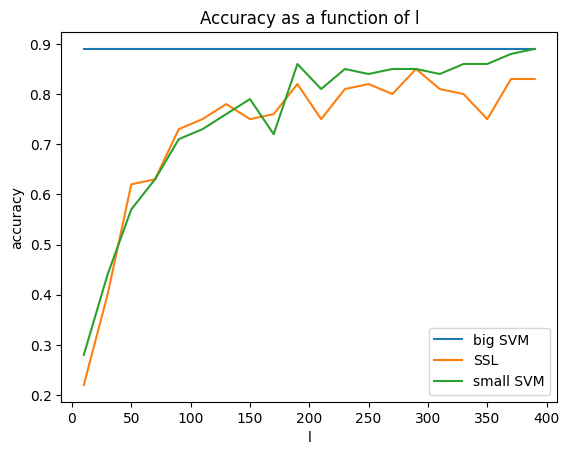

In [102]:
# Display
plt.plot(n_lab, [score_big]*len(n_lab), label="big SVM")
plt.plot(n_lab, SSL_scores, label="SSL")
plt.plot(n_lab, small_SVM_scores, label="small SVM")
plt.title("Accuracy as a function of l")
plt.xlabel('l')
plt.ylabel('accuracy')
plt.legend();

* As supervised algorithm, we used a SVM
* As unsupervised algorithm we used a label propagation algorithm on a KNN-graph build with 5 nearest neighbours


The experimental results demonstrate that the supervised learning algorithm trained on the entire labeled dataset produces the highest accuracy, as expected. Nevertheless, when using a semi-supervised algorithm with 100 labeled and 300 unlabeled data, a higher accuracy by 4% is achieved compared to the supervised algorithm trained on the same 100 labeled data. These results suggest that in the context of face recognition problem, unlabeled data can be beneficial.

However, when varying the number of labeled and unlabeled data, the semi-supervised algorithm outperforms the partially trained SVM only in a narrow range of configurations centered around l=100. This implies that additional unlabeled data does not always lead to better results.

**Remark:** The conclusions can only be applied to the specific case of comparing the performance of SVM algorithm against Label propagation algorithms on KNN-graph.

#### Inductive vs Transductive

* A comparison between a supervised learner (of your choice) trained on the $l$ labeled faces and a semi-supervised learner (of your choice) trained on the $l + u$ labeled and unlabeled faces evaluated on the $N$ revealed points and then on the $m$ unrevealed points.

In [82]:
# Supervised trained on l data
small_SVM = svm.SVC()
small_SVM.fit(x_train[l_idx], y_masked_train[l_idx])
y_pred_test = small_SVM.predict(x_test)

inductive_score = accuracy_score(y_test, y_pred_test)
print(f"SVM trained on {len(l_idx)} data accuracy on test set: {inductive_score}")
y_pred_train = small_SVM.predict(x_train)

transductive_score = accuracy_score(y_train, y_pred_train)
print(f"SVM trained on {len(l_idx)} data accuracy on train set: {transductive_score}")

# Semi-supervised trained on l labelled data and u unlabelled data

SSL_algo = LabelPropagation(kernel='knn', n_neighbors=5)
SSL_algo.fit(x_train, y_masked_train - 1.)

y_pred_test = SSL_algo.predict(x_test) + 1
inductive_score = accuracy_score(y_test, y_pred_test)
print(f"SSL algo trained on {len(l_idx)} labelled data and {len(u_idx)} unlabelled data accuracy on test set: {inductive_score}")

y_pred_train = SSL_algo.predict(x_train) + 1
transductive_score = accuracy_score(y_train, y_pred_train)
print(f"SSL algo trained on {len(l_idx)} labelled data and {len(u_idx)} unlabelled data accuracy on train set: {transductive_score}")

SVM trained on 100 data accuracy on test set: 0.64
SVM trained on 100 data accuracy on train set: 0.8225


c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


SSL algo trained on 100 labelled data and 300 unlabelled data accuracy on test set: 0.69
SSL algo trained on 100 labelled data and 300 unlabelled data accuracy on train set: 0.7525


c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer


In [109]:
n_lab = []
small_SVM_scores_ind = []
small_SVM_scores_trans = []
SSL_scores_ind = []
SSL_scores_trans = []

for i in range(1,40, 2):
    y_masked_train = mask_labels(y_train, i, per_class=True)

    l_idx = np.where(y_masked_train > 0)[0]
    u_idx = np.where(y_masked_train == 0)[0]
    n_lab.append(len(l_idx))

    # Supervised trained on N data
    small_SVM = svm.SVC()
    small_SVM.fit(x_train[l_idx], y_masked_train[l_idx])
    y_pred_test = small_SVM.predict(x_test)
    y_pred_train = small_SVM.predict(x_train)

    small_SVM_scores_ind.append(accuracy_score(y_test, y_pred_test))
    small_SVM_scores_trans.append(accuracy_score(y_train, y_pred_train))

    # Semi-supervised trained on l labelled data and u unlabelled data

    SSL_algo = LabelPropagation(kernel='knn', n_neighbors=5)
    SSL_algo.fit(x_train, y_masked_train - 1.)

    y_pred_test = SSL_algo.predict(x_test) + 1
    y_pred_train = SSL_algo.predict(x_train) + 1

    SSL_scores_ind.append(accuracy_score(y_test, y_pred_test))
    SSL_scores_trans.append(accuracy_score(y_train, y_pred_train))


c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supervised\_label_propagation.py:231: RuntimeWarning: invalid value encountered in divide
  probabilities /= normalizer
c:\Users\cgris\Anaconda3\envs\ISIR\lib\site-packages\sklearn\semi_supe

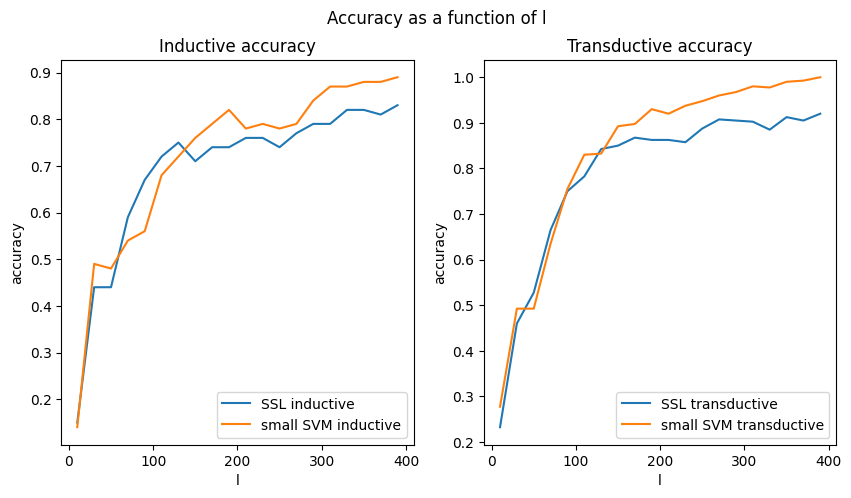

In [111]:
# Display

fig = plt.figure(figsize=(10,5))

fig.add_subplot(1,2,1)
plt.plot(n_lab, SSL_scores_ind, label="SSL inductive")
plt.plot(n_lab, small_SVM_scores_ind, label="small SVM inductive")
plt.title("Inductive accuracy")
plt.xlabel('l')
plt.ylabel('accuracy')
plt.legend()

fig.add_subplot(1,2,2)

plt.plot(n_lab, SSL_scores_trans, label="SSL transductive")
plt.plot(n_lab, small_SVM_scores_trans, label="small SVM transductive")
plt.title("Transductive accuracy")
plt.xlabel('l')
plt.ylabel('accuracy')
plt.legend()

fig.suptitle("Accuracy as a function of l");

*  As supervised algorithm, we use SVM trained on $l$ labelled data
*  As semi-supervised algorithm, we use label propagation on KNN-graph with $k=5$

We observe that in the example with $l=10$ and $u=300$, the SSL algorithm provides better generalization to the test set, while the SVM shows better performance on the training set. In this case, the SSL algorithm outperforms the SVM in terms of inductive error, while the SVM outperforms the SSL algorithm in terms of transductive error.

When varying the number of labelled data $l$ we observe that before $l\approx 100$ both algorithm are equivalent in terms of transductive error, but that in configuration with $l > 100$ the SVM outperforms the SSL algorithm. Yet, like in the previous question, in a small range of value of $l$ around $l=100$ the SSL algorithm better generalizeds on the test set. For the configurations with $l$ in this range of values, the SSL algorithm outperforms the SVM in terms of inductive error. This is reversed for $l>150$, as shows in the above plot. 